In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 62 (delta 32), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (62/62), 3.04 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [5]:
from earlystop import Earlystop

In [6]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [163]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [164]:
batch_size = 32
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),    
    transforms.RandomRotation(9),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1))
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/validation', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [165]:
feature, label = next(iter(trainloader))
print(feature.shape)

torch.Size([32, 3, 224, 224])


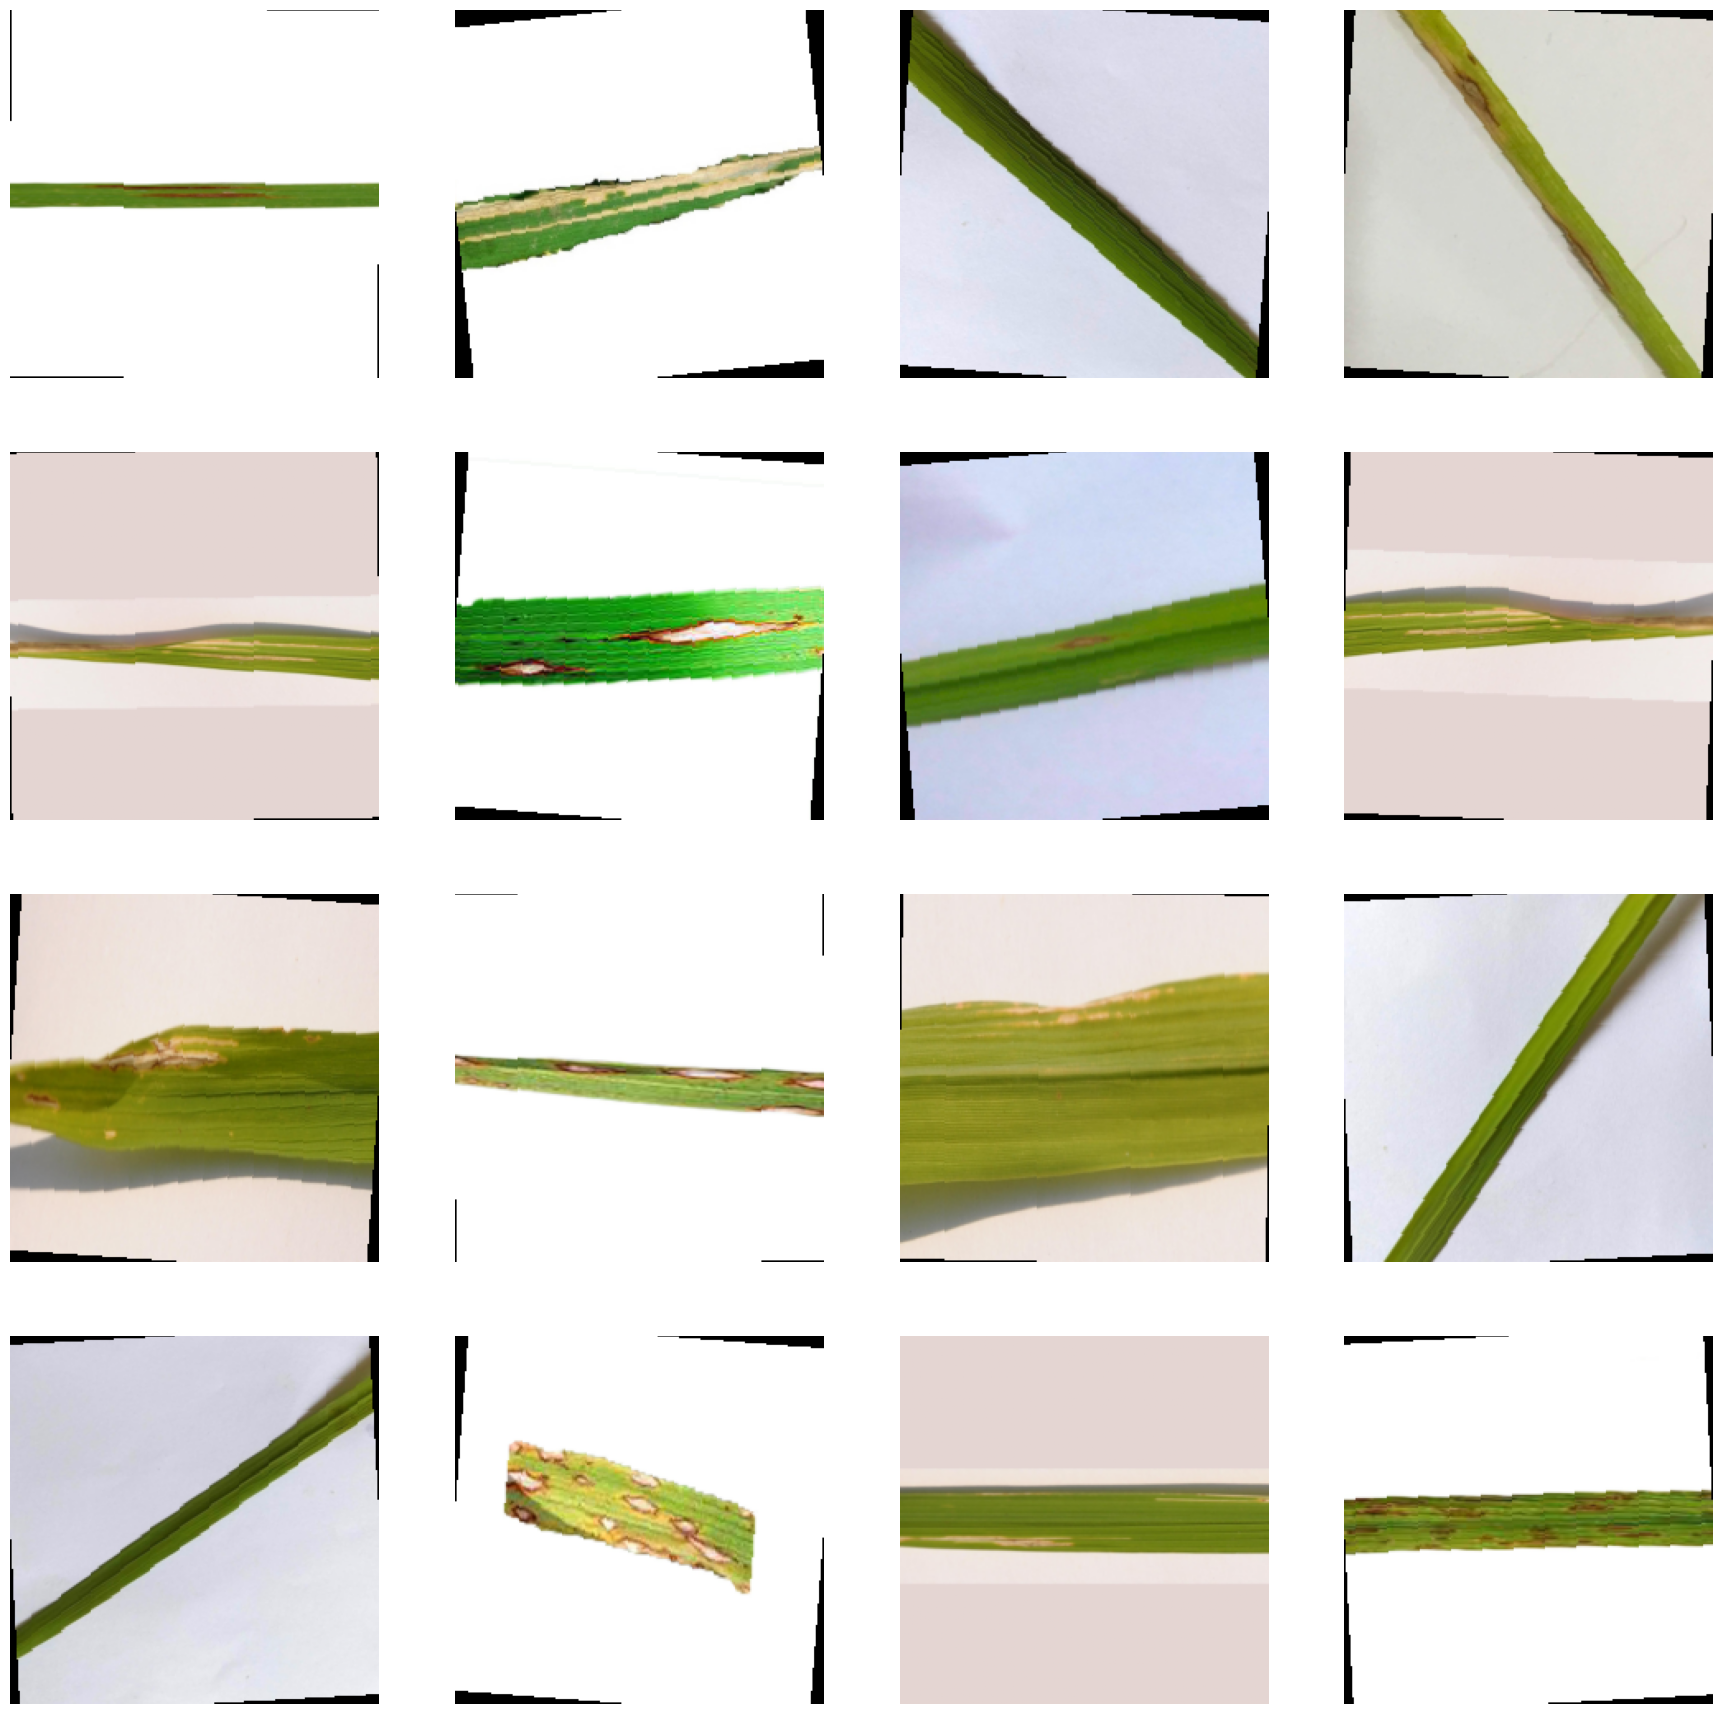

In [166]:
for feature, target in trainloader:
    fig, axis = plt.subplots(4, 4, figsize=(22, 22))
    for i, ax in enumerate(axis.flatten()):
        ax.imshow(feature[i].permute(2, 1, 0))
        ax.axis('off')
    break

In [167]:
def ConvBlock(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
    )

In [196]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(

            ConvBlock(3, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 512),
            nn.MaxPool2d(2,2),
            
            ConvBlock(512, 512),
            nn.MaxPool2d(2,2),
            
        
        )
        self.flatten = nn.Flatten()
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512,output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [197]:
model = CNNpenyakitPadi(len(train_set.classes))
model

CNNpenyakitPadi(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Sequential(
      (0): 

In [198]:
from tqdm import tqdm

In [199]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc


In [200]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [201]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
early_stop = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 100

Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 1: train_loss=1.7662, val_loss=1.7660, train_score=0.2712, val_score=0.3182


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 2: train_loss=1.7080, val_loss=1.7050, train_score=0.3573, val_score=0.4091


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 3: train_loss=1.6531, val_loss=1.6582, train_score=0.4194, val_score=0.5114


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 4: train_loss=1.5938, val_loss=1.6076, train_score=0.5098, val_score=0.5720


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 5: train_loss=1.5511, val_loss=1.5665, train_score=0.5632, val_score=0.5928


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 6: train_loss=1.5177, val_loss=1.5374, train_score=0.5910, val_score=0.5966


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 7: train_loss=1.4920, val_loss=1.5153, train_score=0.5953, val_score=0.6080


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 8: train_loss=1.4731, val_loss=1.5002, train_score=0.6111, val_score=0.6117


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 9: train_loss=1.4585, val_loss=1.4807, train_score=0.6275, val_score=0.6155


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 10: train_loss=1.4431, val_loss=1.4705, train_score=0.6389, val_score=0.6174


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 11: train_loss=1.4316, val_loss=1.4583, train_score=0.6520, val_score=0.6269


Test: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 12: train_loss=1.4174, val_loss=1.4500, train_score=0.6672, val_score=0.6307


Test: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 13: train_loss=1.4094, val_loss=1.4422, train_score=0.6727, val_score=0.6402


Test: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 14: train_loss=1.4015, val_loss=1.4298, train_score=0.6830, val_score=0.6458


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 15: train_loss=1.3934, val_loss=1.4208, train_score=0.6879, val_score=0.6629


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 16: train_loss=1.3845, val_loss=1.4179, train_score=0.6955, val_score=0.6534


Test: 100%|██████████| 17/17 [00:14<00:00,  1.13it/s]


Epoch 17: train_loss=1.3783, val_loss=1.4037, train_score=0.6928, val_score=0.6799


Test: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 18: train_loss=1.3677, val_loss=1.3979, train_score=0.7092, val_score=0.6780


Test: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 19: train_loss=1.3691, val_loss=1.3872, train_score=0.7053, val_score=0.6913


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 20: train_loss=1.3603, val_loss=1.3779, train_score=0.7119, val_score=0.7045


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 21: train_loss=1.3514, val_loss=1.3716, train_score=0.7260, val_score=0.7102


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 22: train_loss=1.3447, val_loss=1.3634, train_score=0.7320, val_score=0.7216


Test: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 23: train_loss=1.3386, val_loss=1.3599, train_score=0.7402, val_score=0.7197


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 24: train_loss=1.3357, val_loss=1.3524, train_score=0.7364, val_score=0.7348


Test: 100%|██████████| 17/17 [00:14<00:00,  1.13it/s]


Epoch 25: train_loss=1.3297, val_loss=1.3454, train_score=0.7407, val_score=0.7405


Test: 100%|██████████| 17/17 [00:14<00:00,  1.13it/s]


Epoch 26: train_loss=1.3305, val_loss=1.3373, train_score=0.7402, val_score=0.7576


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 27: train_loss=1.3270, val_loss=1.3353, train_score=0.7489, val_score=0.7481


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 28: train_loss=1.3257, val_loss=1.3296, train_score=0.7456, val_score=0.7500


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 29: train_loss=1.3148, val_loss=1.3237, train_score=0.7598, val_score=0.7689


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 30: train_loss=1.3127, val_loss=1.3241, train_score=0.7576, val_score=0.7652
EarlyStop patience =  1. Best test_cost: 1.3237


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 31: train_loss=1.3089, val_loss=1.3173, train_score=0.7620, val_score=0.7708


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 32: train_loss=1.3089, val_loss=1.3137, train_score=0.7625, val_score=0.7803


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 33: train_loss=1.3055, val_loss=1.3103, train_score=0.7625, val_score=0.7803


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 34: train_loss=1.3042, val_loss=1.3083, train_score=0.7647, val_score=0.7708


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 35: train_loss=1.2976, val_loss=1.3039, train_score=0.7805, val_score=0.7784


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 36: train_loss=1.2953, val_loss=1.2956, train_score=0.7734, val_score=0.7860


Test: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 37: train_loss=1.2921, val_loss=1.2934, train_score=0.7805, val_score=0.7955


Test: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 38: train_loss=1.2930, val_loss=1.2896, train_score=0.7816, val_score=0.8011


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 39: train_loss=1.2857, val_loss=1.2901, train_score=0.7843, val_score=0.8030
EarlyStop patience =  1. Best test_cost: 1.2896


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 40: train_loss=1.2873, val_loss=1.2847, train_score=0.7854, val_score=0.8125


Test: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 41: train_loss=1.2823, val_loss=1.2836, train_score=0.7881, val_score=0.8068


Test: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 42: train_loss=1.2793, val_loss=1.2845, train_score=0.7816, val_score=0.8049
EarlyStop patience =  1. Best test_cost: 1.2836


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 43: train_loss=1.2814, val_loss=1.2776, train_score=0.7892, val_score=0.8144


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 44: train_loss=1.2752, val_loss=1.2727, train_score=0.8001, val_score=0.8163


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 45: train_loss=1.2763, val_loss=1.2710, train_score=0.7936, val_score=0.8163


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 46: train_loss=1.2741, val_loss=1.2669, train_score=0.7990, val_score=0.8182


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 47: train_loss=1.2719, val_loss=1.2665, train_score=0.8007, val_score=0.8182


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 48: train_loss=1.2685, val_loss=1.2621, train_score=0.8012, val_score=0.8182


Test: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 49: train_loss=1.2665, val_loss=1.2633, train_score=0.7990, val_score=0.8201
EarlyStop patience =  1. Best test_cost: 1.2621


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 50: train_loss=1.2652, val_loss=1.2588, train_score=0.8061, val_score=0.8239


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 51: train_loss=1.2648, val_loss=1.2585, train_score=0.8066, val_score=0.8182


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 52: train_loss=1.2618, val_loss=1.2548, train_score=0.8077, val_score=0.8258


Test: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 53: train_loss=1.2594, val_loss=1.2537, train_score=0.8186, val_score=0.8258


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 54: train_loss=1.2580, val_loss=1.2543, train_score=0.8115, val_score=0.8201
EarlyStop patience =  1. Best test_cost: 1.2537


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 55: train_loss=1.2625, val_loss=1.2522, train_score=0.8083, val_score=0.8239


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 56: train_loss=1.2586, val_loss=1.2492, train_score=0.8034, val_score=0.8295


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 57: train_loss=1.2558, val_loss=1.2483, train_score=0.8083, val_score=0.8239


Test: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 58: train_loss=1.2557, val_loss=1.2473, train_score=0.8105, val_score=0.8277


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 59: train_loss=1.2533, val_loss=1.2439, train_score=0.8099, val_score=0.8333


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 60: train_loss=1.2525, val_loss=1.2498, train_score=0.8132, val_score=0.8201
EarlyStop patience =  1. Best test_cost: 1.2439


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 61: train_loss=1.2545, val_loss=1.2452, train_score=0.8083, val_score=0.8258
EarlyStop patience =  2. Best test_cost: 1.2439
Training early stopped. tidak ada peningkatan pada 2 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 60 | Best test_cost: 1.2439


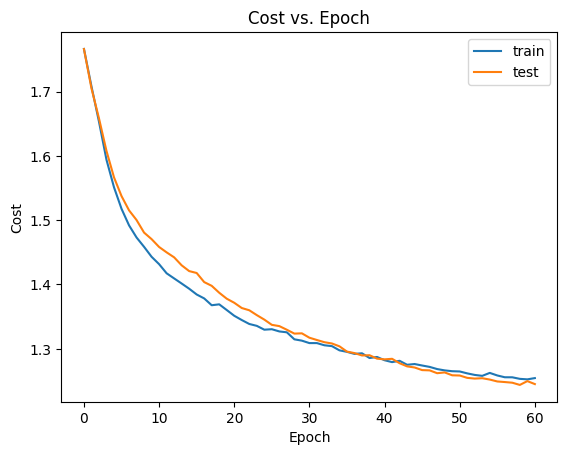

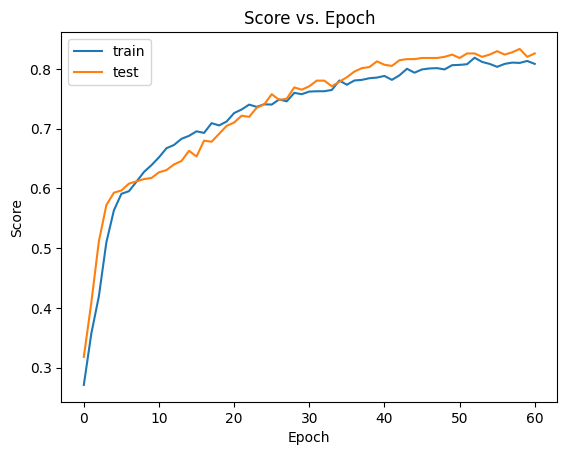

In [202]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epoch)

In [203]:
!pip install torchsummary

In [205]:
test_transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [207]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.2040, Test Accuracy: 0.8750
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.88      0.66      0.75        44
           2       0.89      0.93      0.91        44
           3       0.76      0.77      0.76        44
           4       0.89      0.95      0.92        44
           5       0.86      0.98      0.91        44

    accuracy                           0.88       264
   macro avg       0.88      0.88      0.87       264
weighted avg       0.88      0.88      0.87       264

Confusion Matrix:


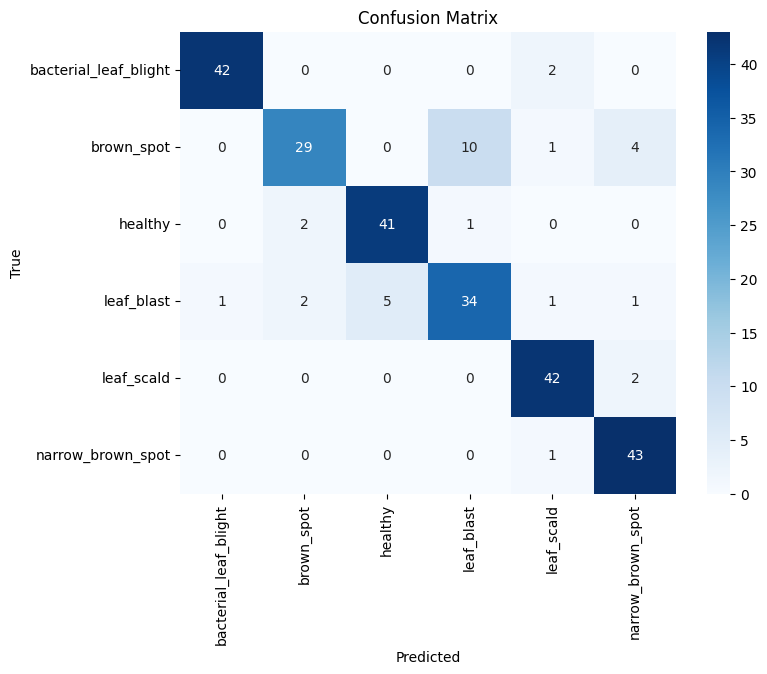

In [208]:
evaluate_model(model, testloader, criterion, device)

In [209]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [216]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_32/1340800542.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


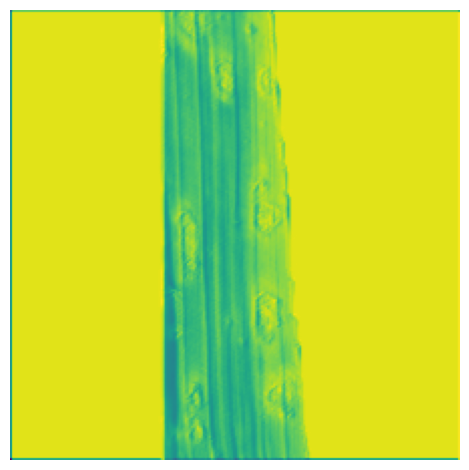

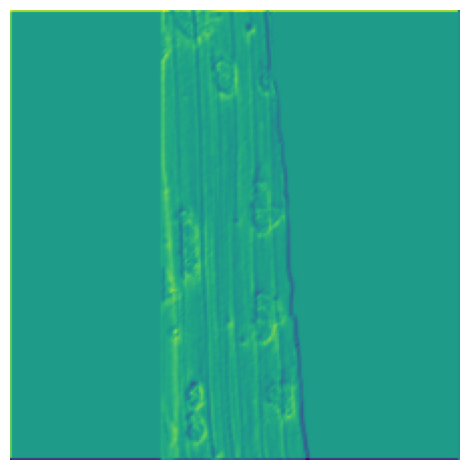

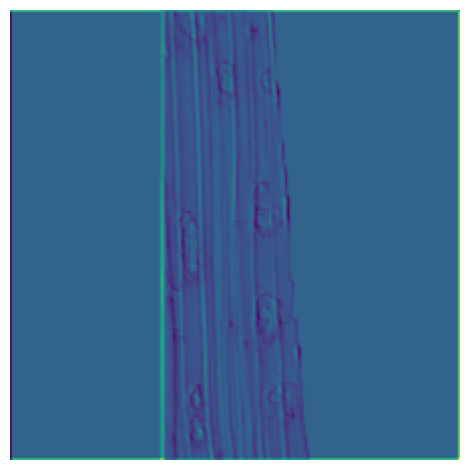

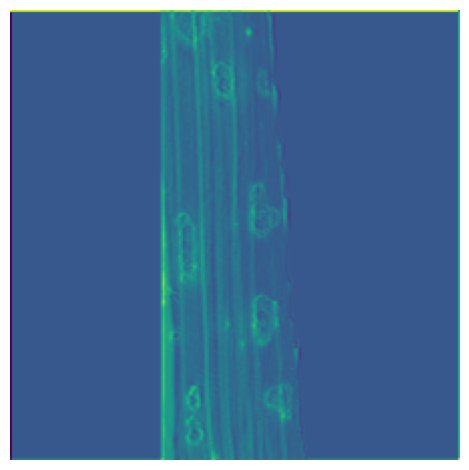

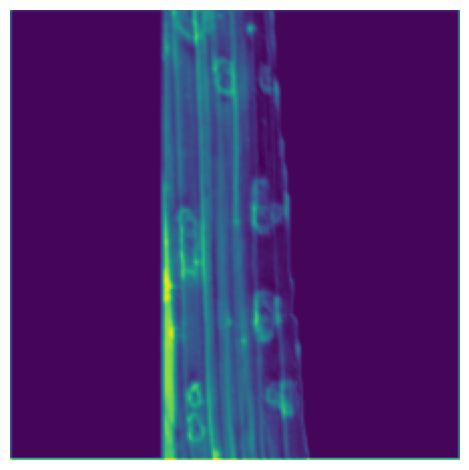

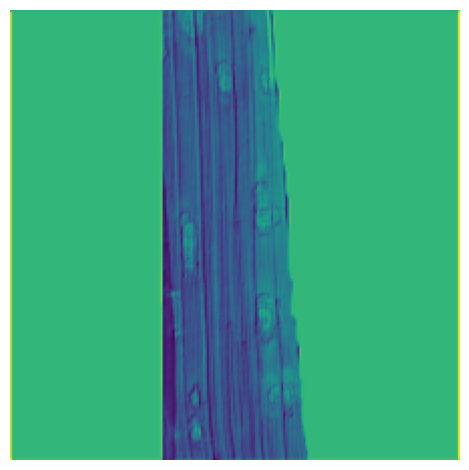

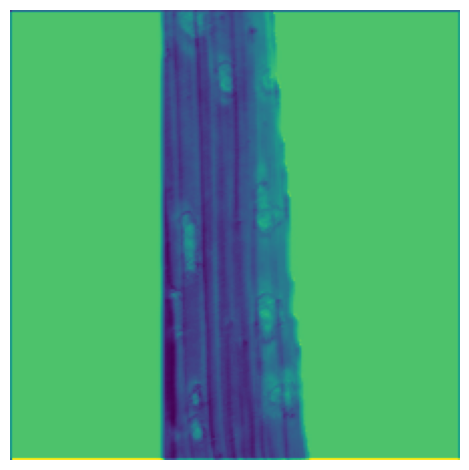

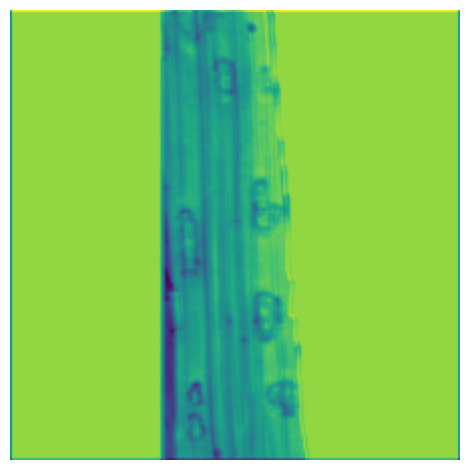

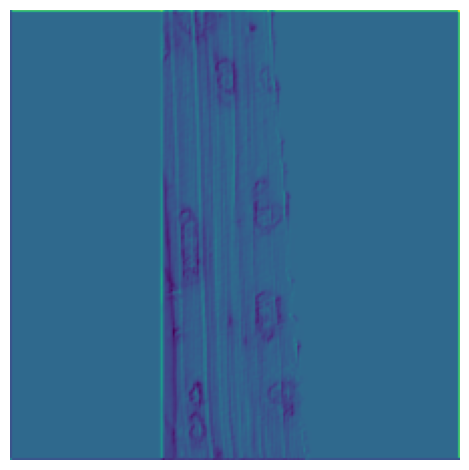

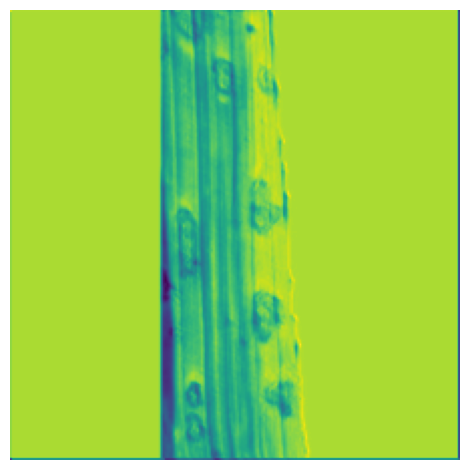

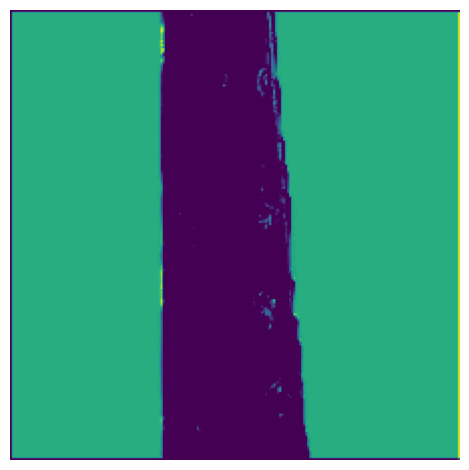

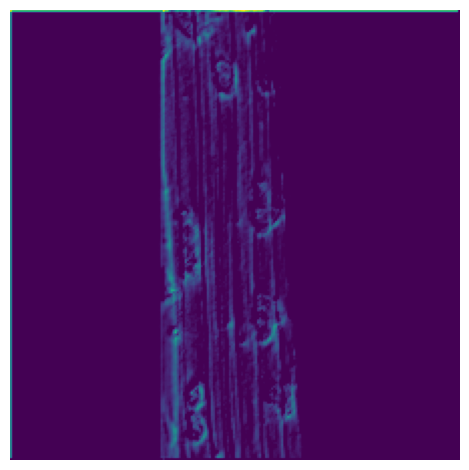

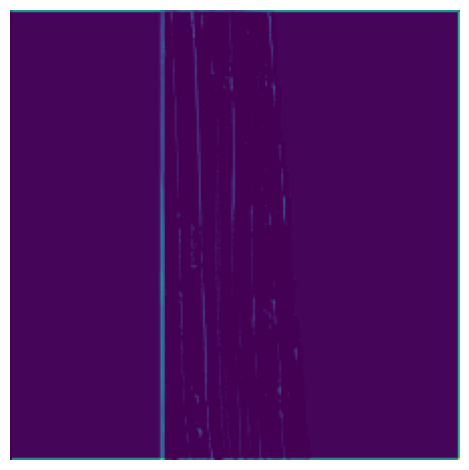

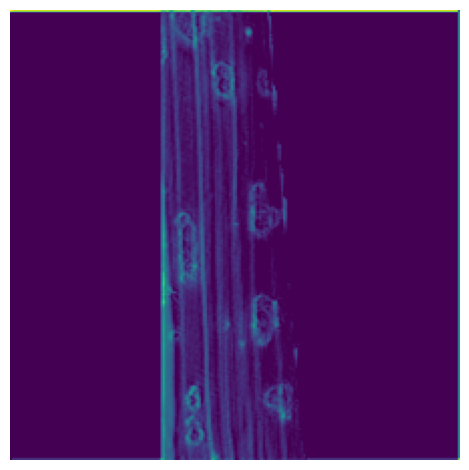

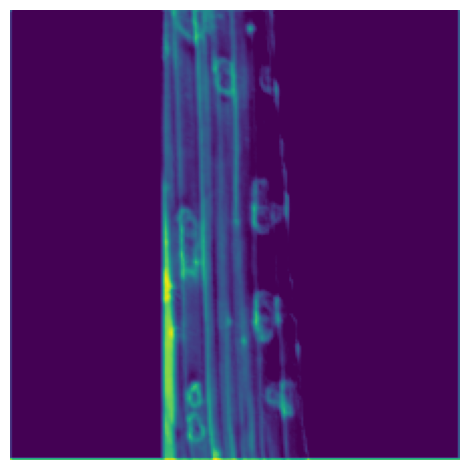

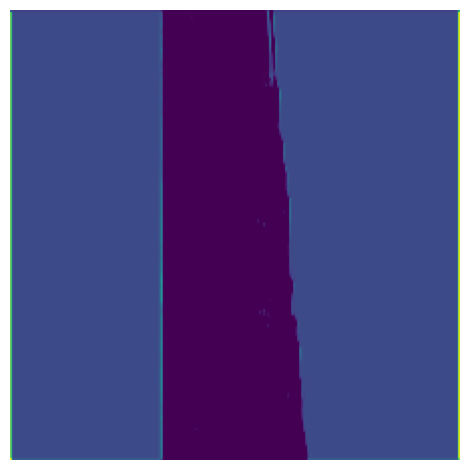

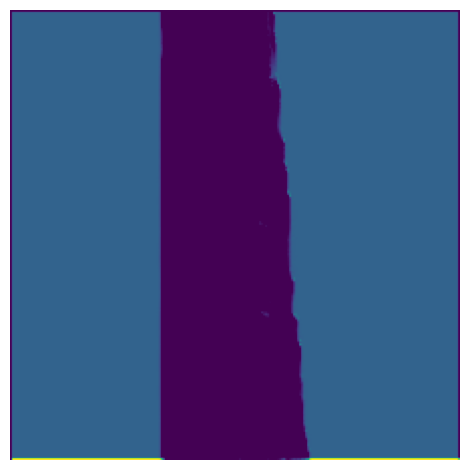

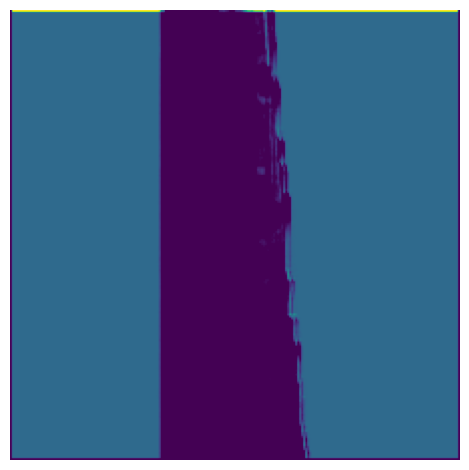

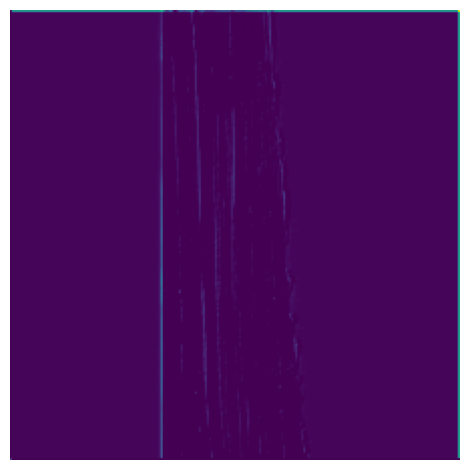

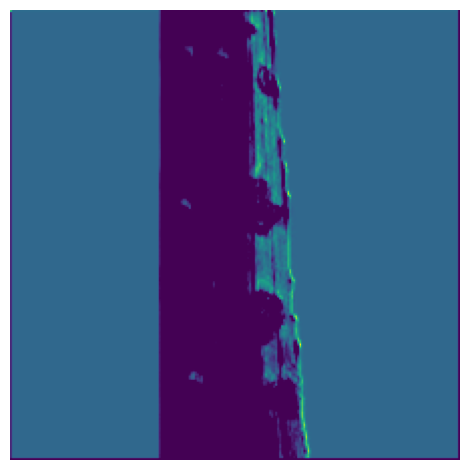

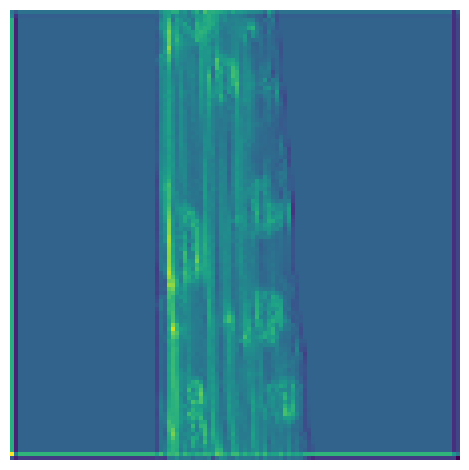

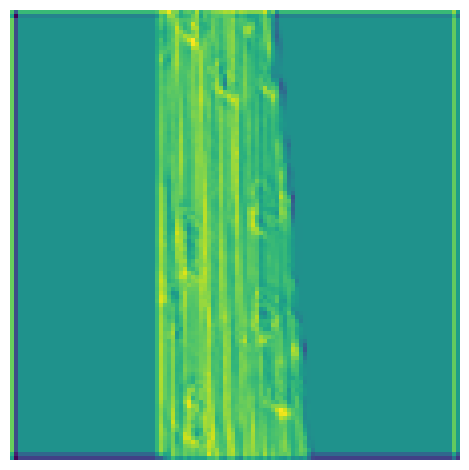

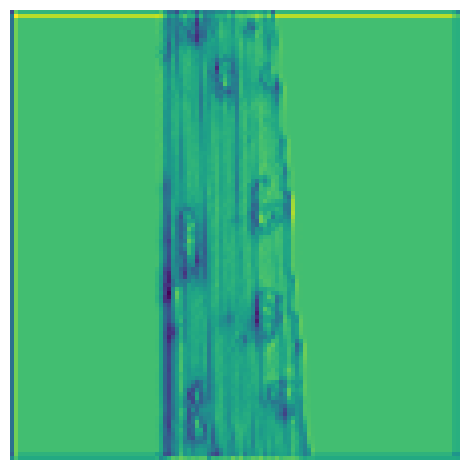

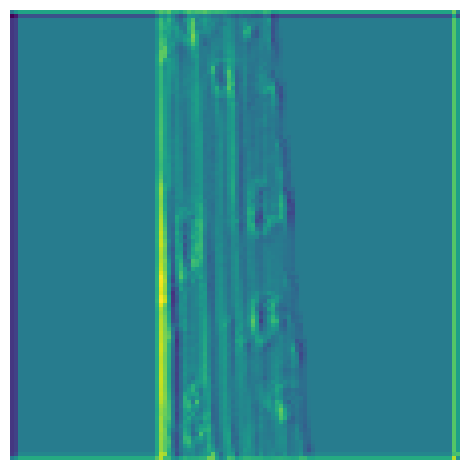

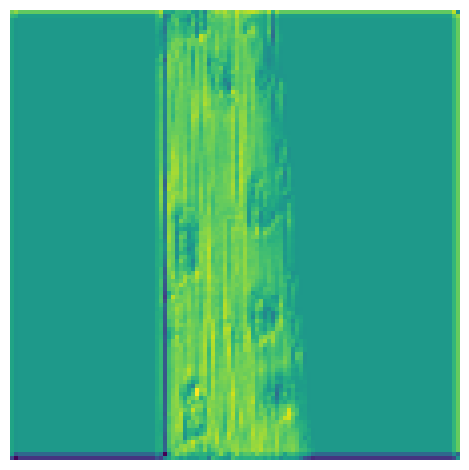

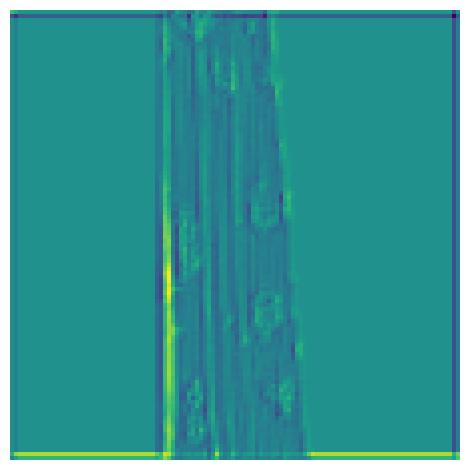

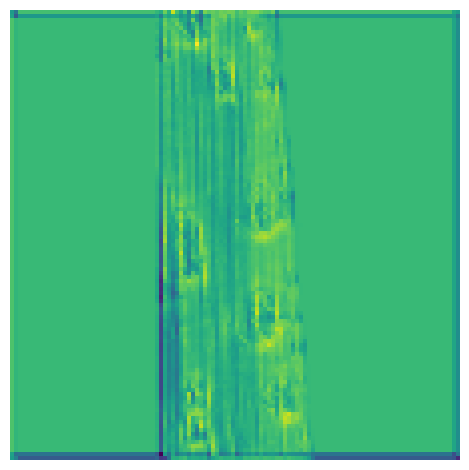

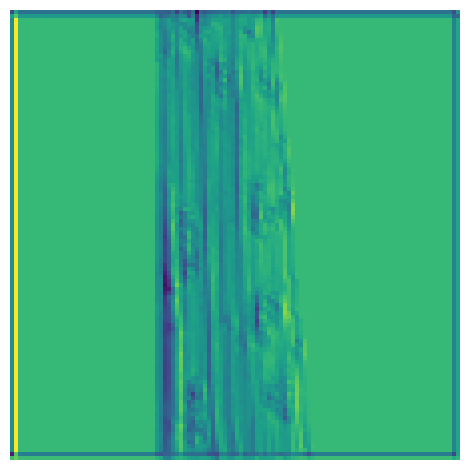

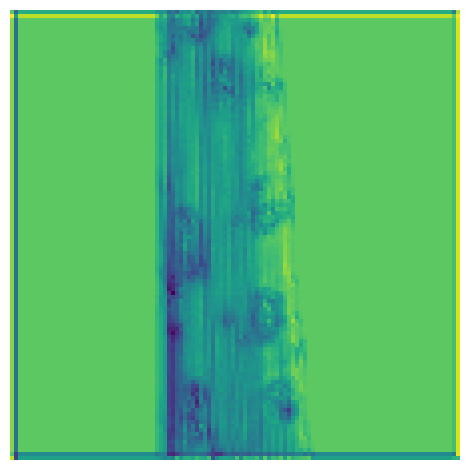

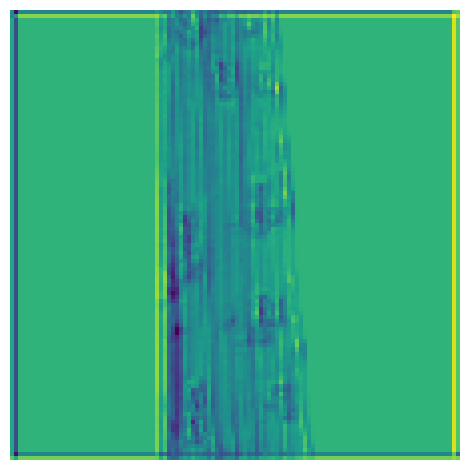

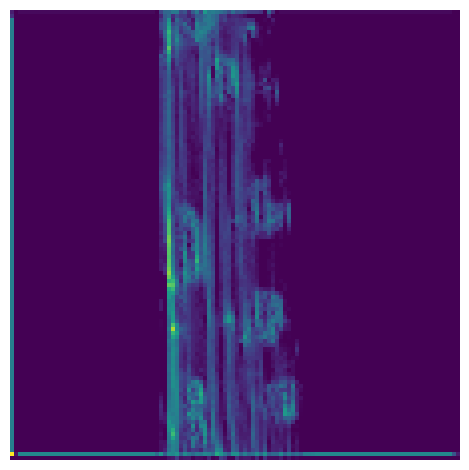

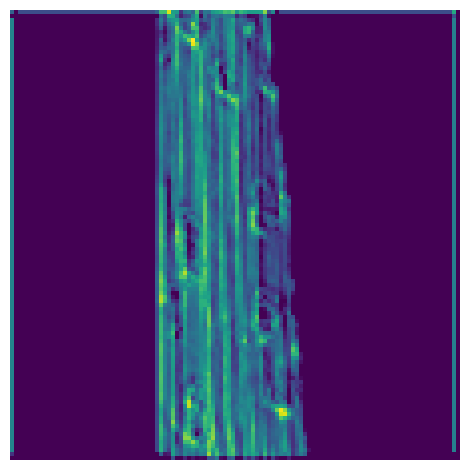

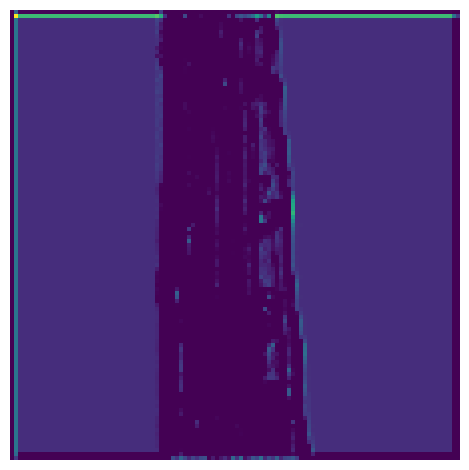

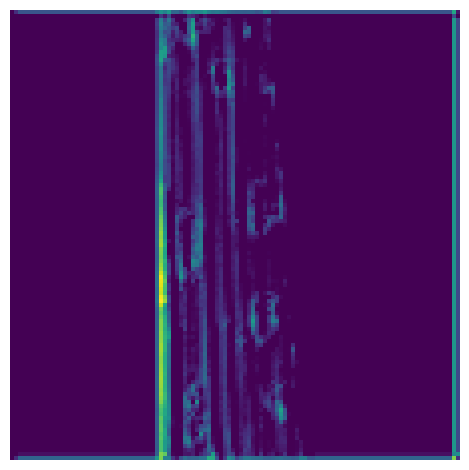

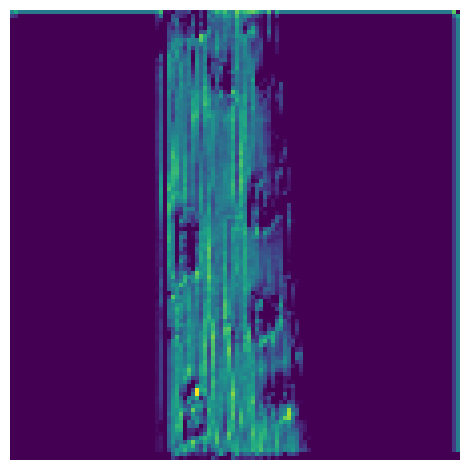

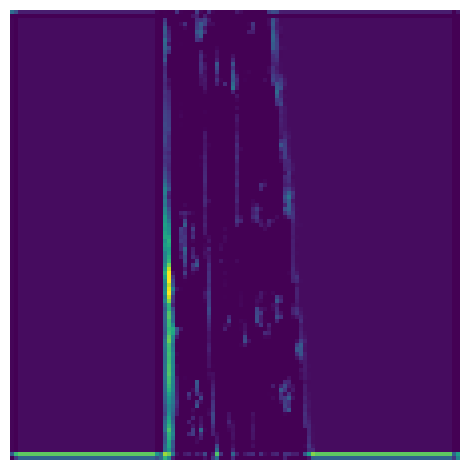

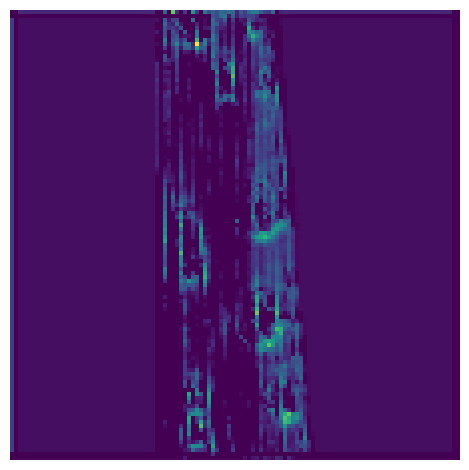

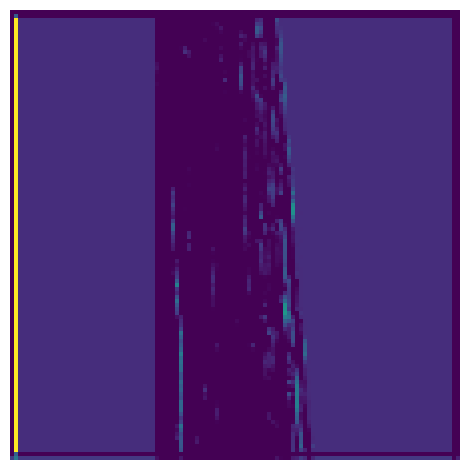

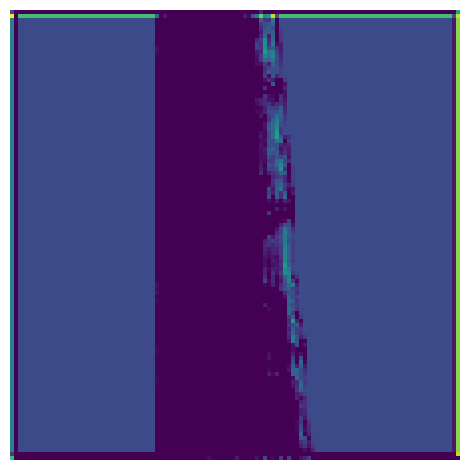

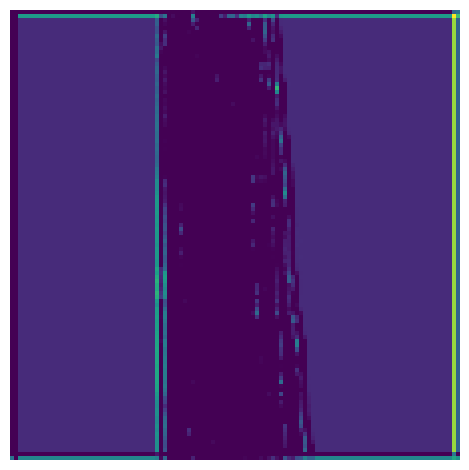

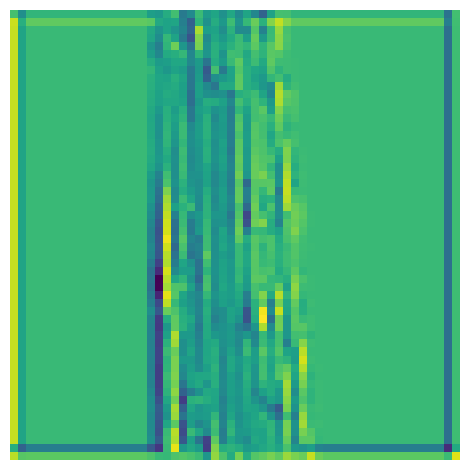

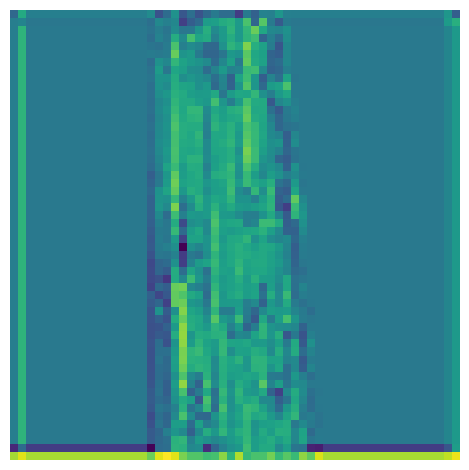

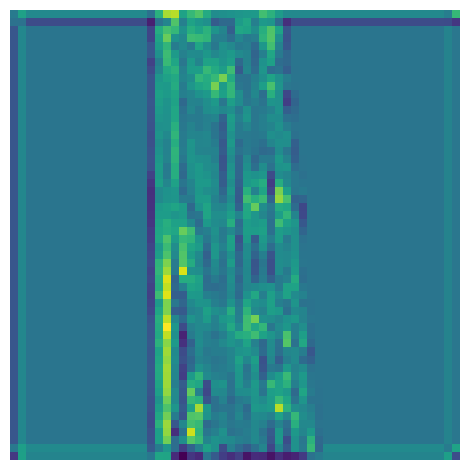

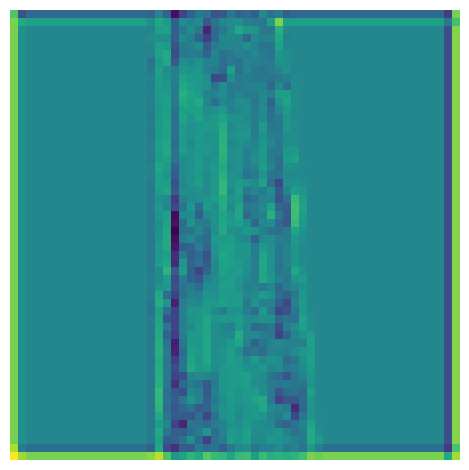

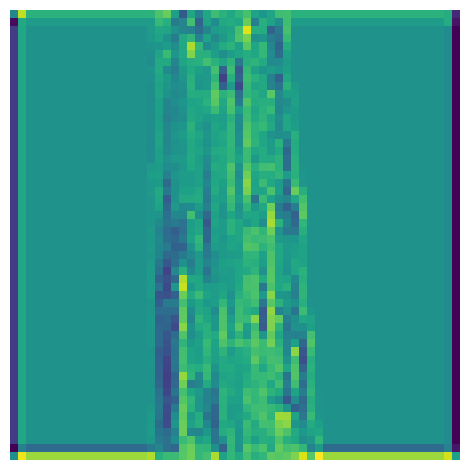

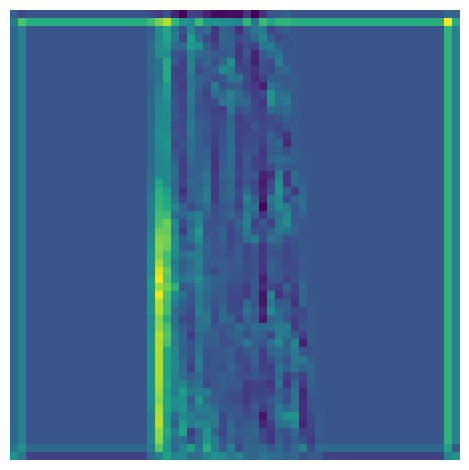

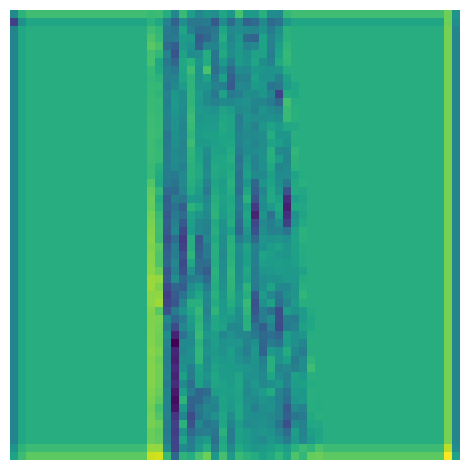

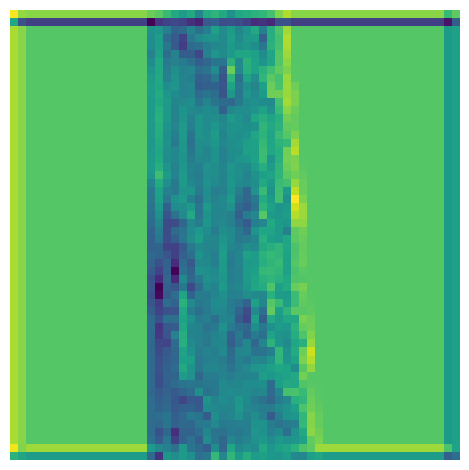

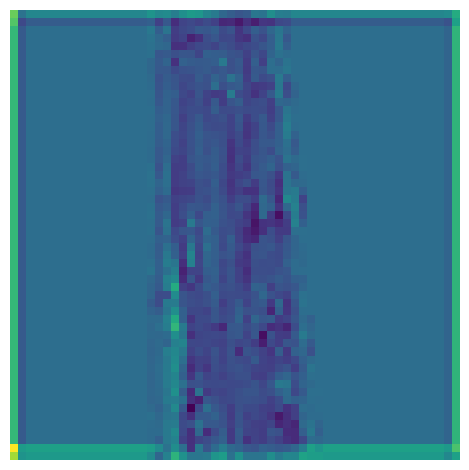

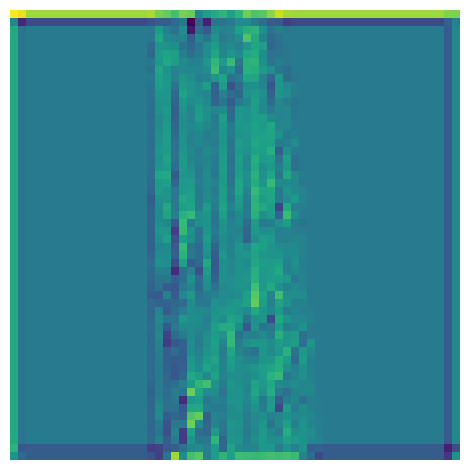

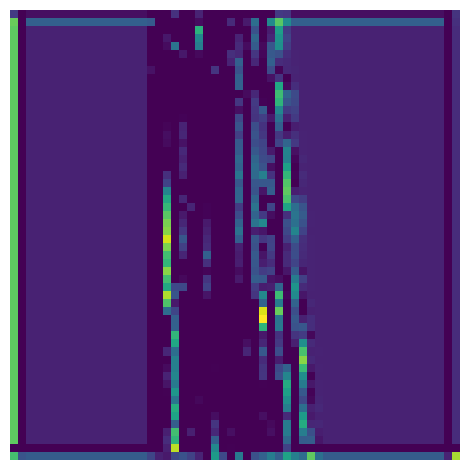

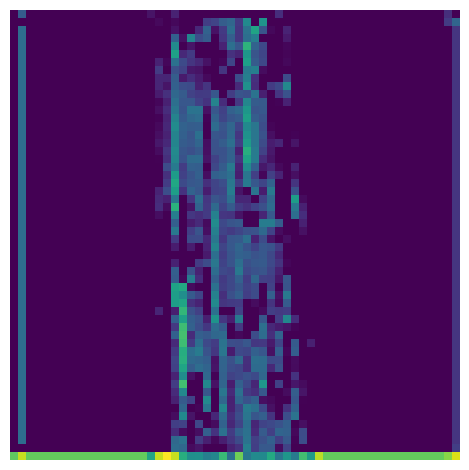

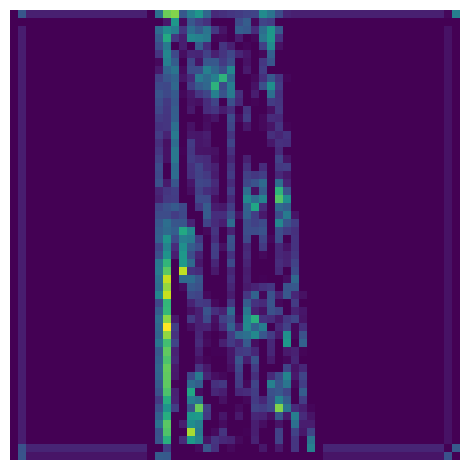

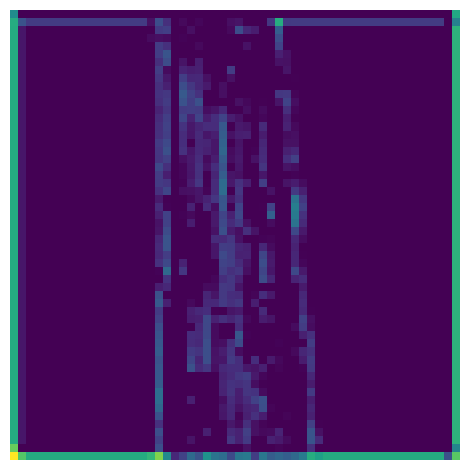

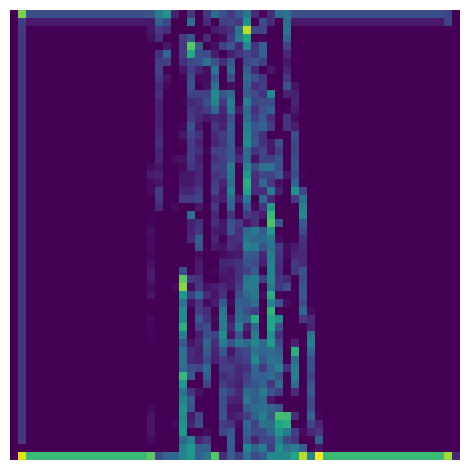

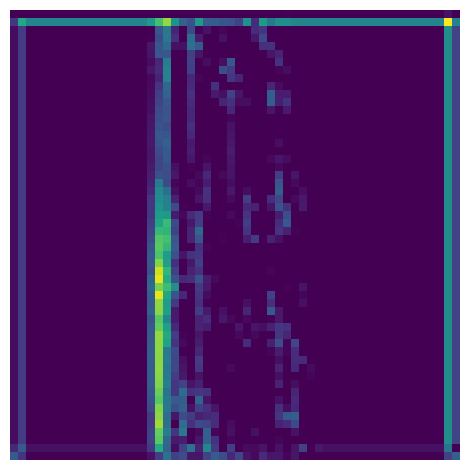

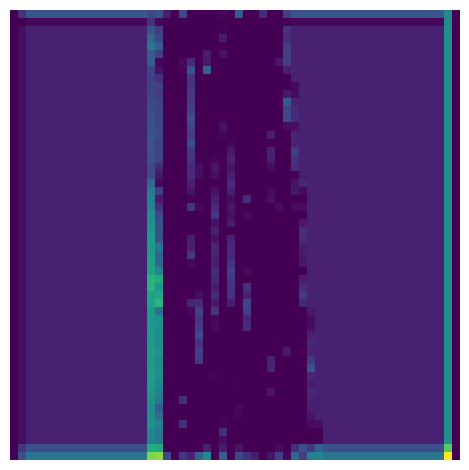

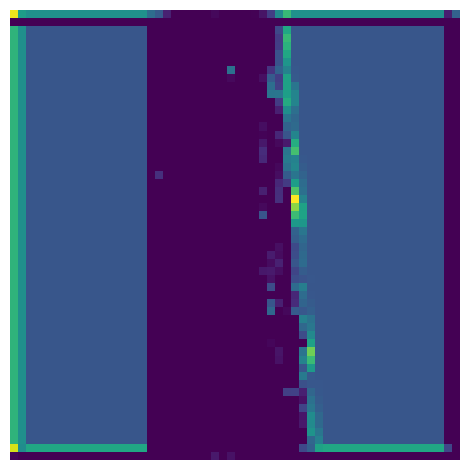

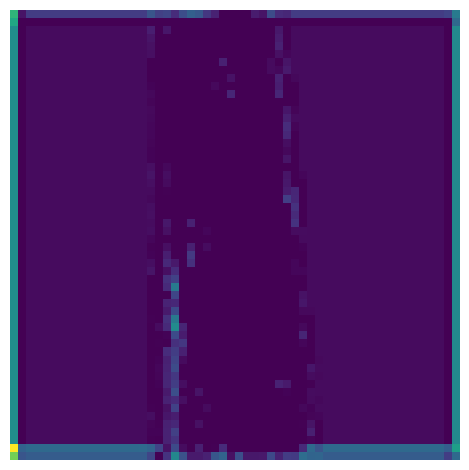

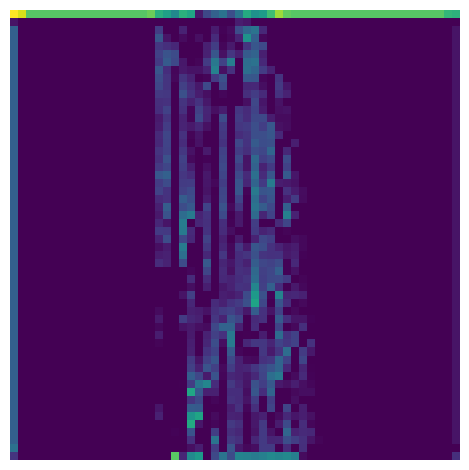

In [218]:
for name in activation1:
    folder_path = os.path.join('custom_1', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

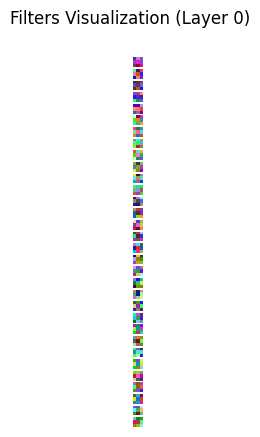

bias :tensor([ 0.1474,  0.0817, -0.0047, -0.1287, -0.0537, -0.1005,  0.0644,  0.1208,
        -0.0910,  0.1037, -0.0926, -0.1164, -0.1576, -0.1677, -0.0809, -0.1316,
        -0.1479, -0.1891, -0.1397,  0.0868,  0.0799, -0.1866,  0.0402,  0.1673,
        -0.0808, -0.1514, -0.1291,  0.0723, -0.0406,  0.0898, -0.0772, -0.0448])


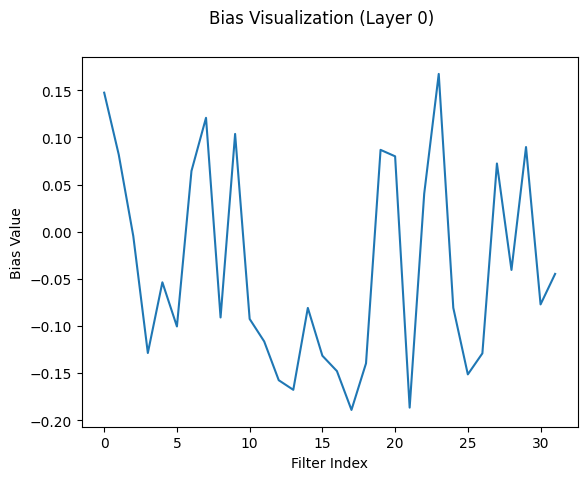

fitur :tensor([[[[ 0.0701, -0.1009, -0.0209,  0.0072, -0.0226, -0.1064],
          [ 0.2955, -0.1201, -0.0973,  0.0481,  0.0310, -0.1159],
          [ 0.2957, -0.1201, -0.0945,  0.0489,  0.0309, -0.1161],
          [ 0.2952, -0.1246, -0.0998,  0.0582,  0.0413, -0.1153],
          [ 0.2957, -0.1255, -0.1186,  0.0692,  0.0460, -0.1150],
          [ 0.5682,  0.3056,  0.1651,  0.2923,  0.4145,  0.3366]],

         [[ 0.0065, -0.0838, -0.0673, -0.0642, -0.0698,  0.1250],
          [-0.2429, -0.1751, -0.0908, -0.1902, -0.1996, -0.0146],
          [-0.2410, -0.1814, -0.1028, -0.1569, -0.2024, -0.0155],
          [-0.2378, -0.1740, -0.1013, -0.1613, -0.2002, -0.0153],
          [-0.2376, -0.1681, -0.0934, -0.1648, -0.2043, -0.0165],
          [-0.3535,  0.0230,  0.1440, -0.0145, -0.0977,  0.0822]],

         [[-0.3848, -0.8098, -0.6720, -0.5730, -0.6928, -0.6527],
          [-0.8034, -1.5434, -1.2866, -1.1519, -1.4029, -1.3415],
          [-0.8006, -1.5424, -1.2894, -1.1233, -1.3888, -1.3412],

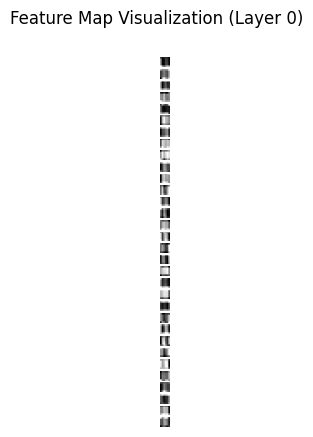

relu :tensor([[[[0.0701, 0.0000, 0.0000, 0.0072, 0.0000, 0.0000],
          [0.2955, 0.0000, 0.0000, 0.0481, 0.0310, 0.0000],
          [0.2957, 0.0000, 0.0000, 0.0489, 0.0309, 0.0000],
          [0.2952, 0.0000, 0.0000, 0.0582, 0.0413, 0.0000],
          [0.2957, 0.0000, 0.0000, 0.0692, 0.0460, 0.0000],
          [0.5682, 0.3056, 0.1651, 0.2923, 0.4145, 0.3366]],

         [[0.0065, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0230, 0.1440, 0.0000, 0.0000, 0.0822]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0

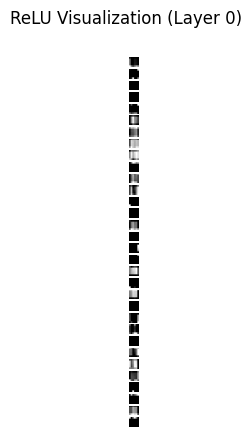

In [220]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)